In [88]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X, y = load_iris(True)

In [3]:
datasets = dict()
targets = dict()
datasets['train'], datasets['val'], targets['train'], targets['val'] = train_test_split(
    X, y, test_size=0.2, random_state=234892, shuffle=True, stratify=y)

In [6]:
for tp in ('train', 'val'):
    datasets[tp] = torch.Tensor(datasets[tp]).double()
for tp in ('train', 'val'):
    targets[tp] = torch.Tensor(targets[tp]).long()
        

In [7]:
model = torch.nn.Sequential(torch.nn.Linear(4, 5), torch.nn.Linear(5,3))
model = model.double()

In [8]:
class IrisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return {'X':self.X[idx], 'y':self.y[idx]}


In [9]:
dataloaders = {'train':DataLoader(IrisDataset(datasets['train'], targets['train']), shuffle=True), 
               'val':DataLoader(IrisDataset(datasets['val'], targets['val']))}

In [10]:
def get_best_class(probas):
    return torch.argmax(probas)

In [57]:
def predict(model, dataloader):
    y_pred = []
    for batch in dataloader:
        X = batch['X']
        pred_proba = model(X)
        y_pred.extend([get_best_class(prob) for prob in pred_proba])
    return y_pred

In [18]:
def train_backprop(model, dataloaders, train_loss, optimizer, num_epochs, true_labels, verbose=False):
    epochs_generator = tqdm(range(1, num_epochs + 1), desc='Epochs', leave=False) if verbose else range(1, num_epochs + 1)
    for epoch in epochs_generator:
        if verbose:
            print(f'Epoch: {epoch}')
        for phase in 'train', 'val':
            if phase == 'train':
                model.train()
            else:
                model.eval()
            if verbose:
                print(f'Phase: {phase}')
            batches_generator = tqdm(dataloaders[phase], desc='Batches', mininterval=0.5) if verbose else dataloaders[phase]
            loss_over_epoch = []
            obj_number = 0
            for batch in batches_generator:
                X = batch['X']
                y = batch['y'].long()
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    pred = model(X)
                    cur_loss = torch.mean(train_loss(pred, y))
                    if phase == 'train':
                        cur_loss.backward()
                        optimizer.step()
                    cur_loss = float(cur_loss)
                    loss_over_epoch.append(cur_loss*len(batch))
                    obj_number += len(batch)
            if verbose:
                print(f'{phase} Loss: {np.sum(loss_over_epoch)/obj_number}')
            if phase == 'val':
                pred_labels = predict(model, dataloaders[phase])
                print(f'Accuracy: {accuracy_score(pred_labels, true_labels)}')

In [21]:
train_loss = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
train_backprop(model, dataloaders, train_loss, optimizer, 10, targets['val'], verbose=False)

Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 0.9666666666666667
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0
Accuracy: 1.0


In [32]:
def get_score(model, dataloader, train_loss):
    loss_over_epoch = []
    obj_number = 0
    with torch.no_grad():
        for batch in dataloader:
            X = batch['X']
            y = batch['y']
            pred = model(X)
            cur_loss = torch.mean(train_loss(pred, y))
            obj_number += len(batch)
            cur_loss = float(cur_loss)
            loss_over_epoch.append(len(batch)*cur_loss)
    return np.sum(loss_over_epoch)/obj_number

def calc_p_star(score, temperature):
    return np.exp(-score / temperature)

In [129]:
def train_simulated_annealing(model, dataloaders, train_loss, annealing_rate, true_labels, num_iter, init_temperature=3 ,random_seed=342, verbose=False):
    """Train model using simulated annealing"""
    iter_generator = tqdm(range(1, num_iter + 1), desc='Iterations', leave=False) if verbose else range(1, num_iter + 1)
    torch.manual_seed(random_seed)
    with torch.no_grad():
        for i in range(2):
            model[i].weight = torch.nn.Parameter(torch.randn_like(model[i].weight)*5)
    temperature = init_temperature
    chosen_weights = [model[i].weight for i in range(2)]
    chosen_score = get_score(model, dataloaders['train'], train_loss)
    for i in iter_generator:
        # if the temperature is low, no need to continue
#         print(calc_p_star(chosen_score, temperature))
            
        cur_weights = [torch.nn.Parameter(torch.randn_like(model[i].weight)*5+chosen_weights[i]) for i in range(2)]
        with torch.no_grad():
            for j in range(2): 
                model[j].weight = torch.nn.Parameter(torch.randn_like(model[j].weight)*5+chosen_weights[j])
        cur_score = get_score(model, dataloaders['train'], train_loss)
        acceptance_ratio = calc_p_star(cur_score, temperature) / calc_p_star(chosen_score, temperature)
        u = np.random.uniform(0, 1)
        if u < acceptance_ratio:
            chosen_weights = [model[i].weight for i in range(2)]
            chosen_score = cur_score
        temperature *= annealing_rate
        with torch.no_grad():
            for j in range(2): 
                model[j].weight = chosen_weights[j]
        pred_labels = predict(model, dataloaders['val'])
#         print(f'Accuracy: {accuracy_score(pred_labels, true_labels)}')
    pred_labels = predict(model, dataloaders['val'])
    return accuracy_score(pred_labels, true_labels)

In [126]:
model_sa = torch.nn.Sequential(torch.nn.Linear(4, 5), torch.nn.Linear(5,3)).double()

In [127]:
accuracies = []
for annealing_rate in np.linspace(0.9, 1, 100):
    #run 5 times wit different random seeds
    sum_accuracies = 0
    for it in range(20):
        sum_accuracies += train_simulated_annealing(model_sa, dataloaders, train_loss, annealing_rate, targets['val'], 100, 3, np.random.randint(10000000))
    accuracies.append(sum_accuracies/20)

/home/kolya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/kolya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/home/kolya/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars


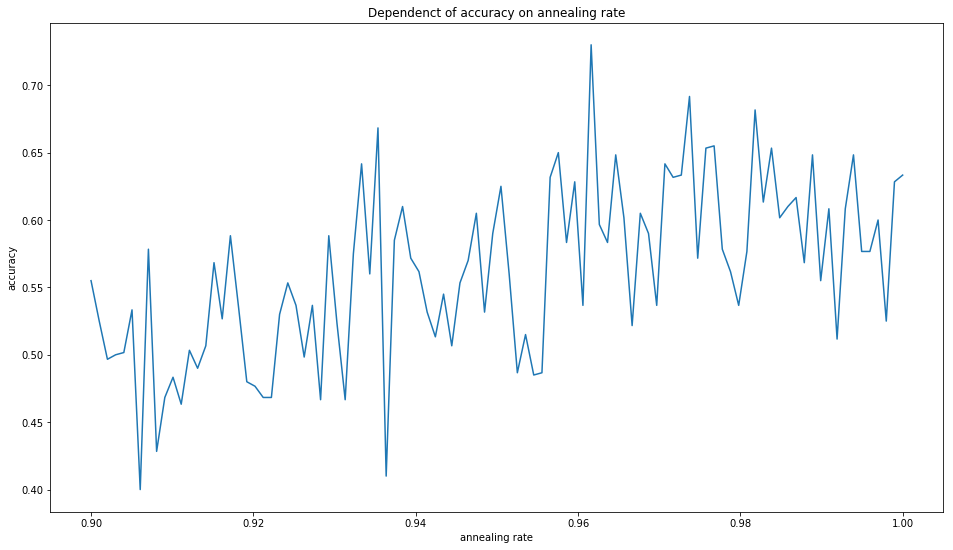

In [132]:
plt.rcParams['figure.figsize'] = (16,9)
plt.plot(np.linspace(0.9, 1, 100), accuracies)
plt.title('Dependenct of accuracy on annealing rate')
plt.xlabel('annealing rate')
plt.ylabel('accuracy')
plt.show()

8990677